In [14]:
import pandas as pd
import numpy as np
import transformers as trans
import pickle
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import optuna
import shap
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [2]:
df_train = pd.read_csv('data/train-student-mat.csv')

X_train = df_train.drop(['Unnamed: 0', 'id', 'Final_Score', 'G1', 'G2', 'G3'],
                        axis=1)
y_train = df_train['Final_Score']

df_test = pd.read_csv('data/test-student-mat.csv')
X_test = df_test.drop(['Unnamed: 0', 'id', 'Final_Score', 'G1', 'G2', 'G3'],
                      axis=1)
y_test = df_test['Final_Score']

In [3]:
cat_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob',
                'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid',
                'activities', 'nursery', 'higher', 'internet', 'romantic']

In [4]:
label_cat = trans.OrdinalEncoderDF(cat_features)
X_train_trans = label_cat.fit_transform(X_train)
X_test_trans = label_cat.fit_transform(X_test)

In [5]:
X_train_trans.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,0,0,17,1,0,1,1,1,0,2,...,1,1,0,5,3,3,1,1,3,4
1,0,0,15,1,1,1,1,1,0,2,...,1,1,0,4,3,2,2,3,3,10
2,0,0,16,1,0,1,3,3,2,2,...,1,0,0,4,3,2,1,2,5,4
3,0,1,16,1,1,1,2,2,2,2,...,1,1,0,4,4,4,1,1,3,0
4,0,1,15,1,1,0,3,2,3,2,...,1,1,0,4,2,2,1,1,1,0


In [6]:
best_booster = None
xbr = None

In [34]:
def objective(trial):
    global xbr
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 10, 500, step=1),
        'max_depth': trial.suggest_int('max_depth', 1, 12, step=1),       
        
    }
    
    xbr = XGBRegressor(**param)
    xbr.fit(X_train_trans, y_train)
    #y_pred = xbr.predict(X_test_trans)
    scores = cross_val_score(estimator = xbr, X = X_train_trans, y = y_train, scoring='neg_root_mean_squared_error', cv = 5)
    #r2 = r2_score(y_test, y_pred)
    trial.set_user_attr(key="best_booster", value=xbr)

    return scores.mean()

In [35]:
def callback(study, trial):
    global best_booster
    if study.best_trial == trial:
        best_booster = xbr

In [36]:
study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="maximize"
    )
study.optimize(objective, n_trials=10, callbacks=[callback])

[I 2023-08-12 18:56:14,914] A new study created in memory with name: no-name-335609e1-f606-4aa6-a89a-503b160345be
[I 2023-08-12 18:56:16,110] Trial 0 finished with value: -3.7101426592501654 and parameters: {'learning_rate': 0.0666325247388388, 'n_estimators': 279, 'max_depth': 3}. Best is trial 0 with value: -3.7101426592501654.
[I 2023-08-12 18:56:18,735] Trial 1 finished with value: -3.7466728530420204 and parameters: {'learning_rate': 0.09654787908074931, 'n_estimators': 492, 'max_depth': 11}. Best is trial 0 with value: -3.7101426592501654.
[I 2023-08-12 18:56:20,757] Trial 2 finished with value: -3.675061902080754 and parameters: {'learning_rate': 0.0538096537940833, 'n_estimators': 192, 'max_depth': 10}. Best is trial 2 with value: -3.675061902080754.
[I 2023-08-12 18:56:25,384] Trial 3 finished with value: -3.8310671608029194 and parameters: {'learning_rate': 0.022450839172075757, 'n_estimators': 459, 'max_depth': 9}. Best is trial 2 with value: -3.675061902080754.
[I 2023-08-1

In [37]:
y_pred_xbr = xbr.predict(X_test_trans)

In [38]:
def adj_r2_fun(r2, n, p):
    adj_rsquared = 1 - (1 - r2) * ((n - 1)/(n-p-1))
    return adj_rsquared

In [39]:
print(f'MAE: {mean_absolute_error(y_test, y_pred_xbr):.2f}')
print(f'RMSE: {mean_squared_error(y_test, y_pred_xbr):.2f}')
print(f'R2: {r2_score(y_test, y_pred_xbr):.2f}')
print(f'Adj R2: {adj_r2_fun(r2_score(y_test, y_pred_xbr), len(y_test), X_test.shape[1]):.2f}')

MAE: 2.84
RMSE: 11.75
R2: 0.24
Adj R2: -0.02


In [ ]:
### round predicted values 

In [40]:
file_name = "xgb_reg.pkl"
# save
pickle.dump(xbr, open(file_name, "wb"))

In [42]:
df_importance = pd.DataFrame(zip(X_train_trans.columns, xbr.feature_importances_),
                             columns=['feature', 'importance'
                                      ]).sort_values('importance', ascending=False)

In [51]:
df_importance

,feature,importance
14,failures,0.307833
20,higher,0.099200
29,absences,0.058220
15,schoolsup,0.046021
25,goout,0.042557
12,traveltime,0.036320
11,guardian,0.031791
28,health,0.028087
9,Fjob,0.026318
10,reason,0.024054


<Axes: xlabel='feature', ylabel='importance'>

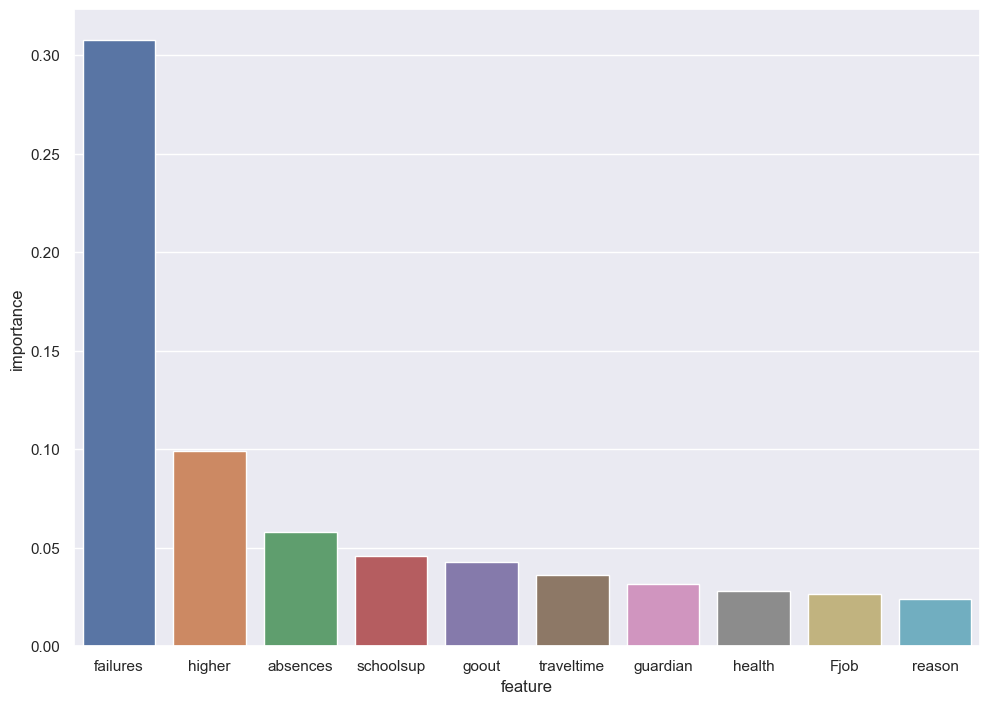

In [52]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=df_importance[:10], x="feature", y="importance")

In [54]:
explainer = shap.TreeExplainer(xbr)
shap_values = explainer.shap_values(X_train_trans)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


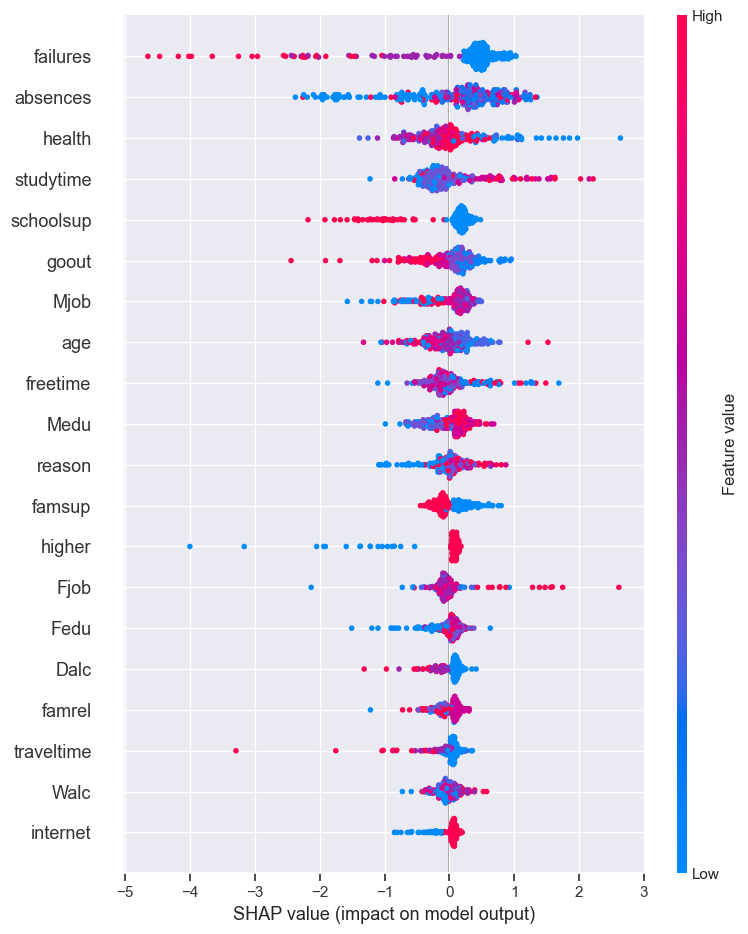

In [55]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train_trans)